In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('/Users/isaromobru/Desktop/FakeNews 10.57.24/proyecto_machine_learning_Fake_News/notebooks/processedstopword.csv')

## División de X e y

In [6]:
df['text'] = df['text'].fillna("")
df['title'] = df['title'].fillna("")
df['subject'] = df['subject'].fillna("")

# Extraer características y etiquetas
X = df[['text','title','subject']]  # Usaremos el texto del artículo como entrada
y = df['label'] # La variable objetivo

# Convertir el texto en una representación numérica usando TF-IDF
vectorizer = TfidfVectorizer(max_features=3000)  # Limitar a 5000 características para optimización
X_tfidf = vectorizer.fit_transform(X)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [3, 44689]

In [7]:
print("Forma de X_tfidf:", X_tfidf.shape)
print("Número de muestras en y:", len(y))


Forma de X_tfidf: (3, 3)
Número de muestras en y: 44689


In [8]:
# Rellenar valores nulos
df['text'] = df['text'].fillna("")
df['title'] = df['title'].fillna("")

# Verifica la cantidad de muestras
print("Muestras en df['text']:", len(df['text']))  # Debería ser 44689

# Aplica la vectorización
tfidf_text = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf_text.fit_transform(df['text'])
print("Forma de X_tfidf:", X_tfidf.shape)



Muestras en df['text']: 44689
Forma de X_tfidf: (44689, 10000)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


## Regresión Logística

In [25]:

# Entrenar el modelo de Regresión Logística
logreg_model = LogisticRegression(max_iter=500, solver='liblinear')  # Solver optimizado para datos grandes
logreg_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_logreg = logreg_model.predict(X_test)

# Evaluar el modelo
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
class_report_logreg = classification_report(y_test, y_pred_logreg)

# Mostrar los resultados
conf_matrix_logreg, class_report_logreg

(array([[4587,   61],
        [  62, 4228]]),
 '              precision    recall  f1-score   support\n\n           0       0.99      0.99      0.99      4648\n           1       0.99      0.99      0.99      4290\n\n    accuracy                           0.99      8938\n   macro avg       0.99      0.99      0.99      8938\nweighted avg       0.99      0.99      0.99      8938\n')

El modelo indica unos valores muy altos.
- Precisión= 0,99, lo que quiere decir un 99% de precisión 
- f1-score y Recall= Respectivamente estos indicadores muestran que tan bien el modelo encuentra todos los casos de una clase y el balance entre precisión y recall, en nuestro caso un 0,99

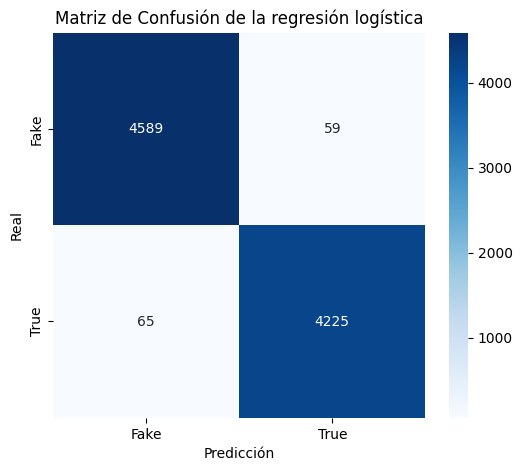

In [26]:
# Definir valores de la matriz de confusión
cm = np.array([[4589, 59],
               [65, 4225]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión de la regresión logística')
plt.show();


Esta matriz de confusión nos indica que nuestro modelo clasifica 4589 fakes cuando son fake, 4225 True cuando son True. 
Por otro lado, se equivoca clasificando Fake cuando es True 65 y True cuando es Fake 59, son valores bastante bajos teniendo en cuenta el tamaño de la muestra 

la regresión logística tiene una precisión muy alta de un 0,99, por lo que voy a comprobar si tiene overfitting

In [14]:
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report

# 5. Evaluación del modelo
# Predicciones
y_train_pred_proba = logreg_model.predict_proba(X_train)[:, 1]  # Probabilidad de la clase 1 en entrenamiento
y_test_pred_proba = logreg_model.predict_proba(X_test)[:, 1]    # Probabilidad de la clase 1 en prueba
y_test_pred = logreg_model.predict(X_test)

# Cálculo de log loss
log_loss_train = log_loss(y_train, y_train_pred_proba)
log_loss_test = log_loss(y_test, y_test_pred_proba)

log_loss_train, log_loss_test

(0.06175222933010205, 0.0689247650154716)

La log loss (pérdida logarítmica) es una métrica que mide qué tan bien un modelo de clasificación predice probabilidades en lugar de simplemente etiquetas. Se usa especialmente en modelos de clasificación binaria y multiclase.
La diferencia en nuestro caso es muy pequeña (0,0072) lo que indica que nuestro modelo genera bien y no causa overfitting


## XG-Boost

In [27]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    eval_metric='logloss',   # Métrica de evaluación
    use_label_encoder=False, # Evita el warning innecesario
    max_depth=6,             # Controla la complejidad del modelo
    learning_rate=0.1,       # Tasa de aprendizaje equilibrada
    n_estimators=300,        # Aumenta el número de árboles para mejorar el ajuste
    subsample=0.8,           # Reduce overfitting usando solo el 80% de los datos por árbol
    colsample_bytree=0.8,    # Usa el 80% de las características en cada árbol
    gamma=0.1,               # Ayuda a la regularización
    reg_lambda=1,            # Regularización L2 para evitar overfitting
    reg_alpha=0.1            # Regularización L1
)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

# Predicciones
y_pred_xgb = xgb_model.predict(X_test)

# Evaluar el modelo
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
class_report = classification_report(y_test, y_pred_xgb, digits=4)

# Mostrar los resultados
conf_matrix, class_report


/Users/isaromobru/Desktop/FakeNews 10.57.24/proyecto_machine_learning_Fake_News/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


(array([[4636,   12],
        [  11, 4279]]),
 '              precision    recall  f1-score   support\n\n           0     0.9976    0.9974    0.9975      4648\n           1     0.9972    0.9974    0.9973      4290\n\n    accuracy                         0.9974      8938\n   macro avg     0.9974    0.9974    0.9974      8938\nweighted avg     0.9974    0.9974    0.9974      8938\n')

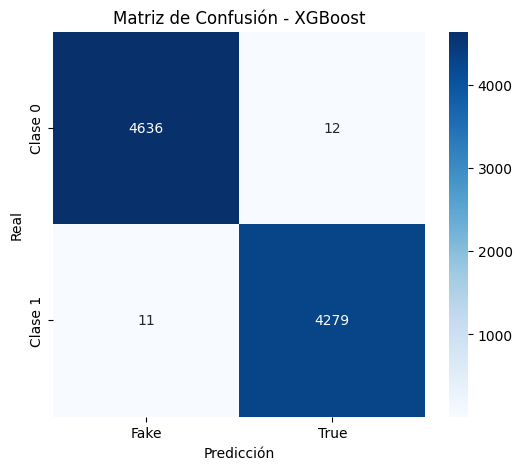

/Users/isaromobru/Desktop/FakeNews 10.57.24/proyecto_machine_learning_Fake_News/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:43:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/isaromobru/Desktop/FakeNews 10.57.24/proyecto_machine_learning_Fake_News/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:45:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/isaromobru/Desktop/FakeNews 10.57.24/proyecto_machine_learning_Fake_News/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:46:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/isaromobru/Desktop/FakeNews 10.57.24/proyecto_machine_learni

(np.float64(0.9965315549013652), np.float64(0.0012796814234147282))

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap([[4636, 12], [11, 4279]], annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - XGBoost')
plt.show()

# Evaluación de overfitting usando validación cruzada
cv_scores = cross_val_score(xgb_model, X_tfidf, y, cv=5, scoring='accuracy')

# Mostrar los resultados de validación cruzada
cv_scores.mean(), cv_scores.std()


Alta precisión en validación cruzada (99.65%)
El modelo es consistentemente preciso en diferentes subconjuntos de los datos.
Si hubiera overfitting, esperaríamos una caída más pronunciada en los datos de validación.
Baja variabilidad entre folds (0.0013)
La desviación estándar es muy pequeña (0.13%), lo que indica que el modelo es estable y generaliza bien en diferentes subconjuntos.
Si la desviación estándar fuera alta (>2-3%), el modelo sería inconsistente.


In [29]:
# Calcular las probabilidades predichas para calcular log loss
y_train_pred_probaxgb = xgb_model.predict_proba(X_train)[:, 1]  # Probabilidad de la clase 1 en entrenamiento
y_test_pred_probaxgb = xgb_model.predict_proba(X_test)[:, 1]    # Probabilidad de la clase 1 en prueba

# Calcular log loss en entrenamiento y prueba
log_loss_train = log_loss(y_train, y_train_pred_probaxgb)
log_loss_test = log_loss(y_test, y_test_pred_probaxgb)

# Mostrar los resultados
log_loss_train, log_loss_test


(0.000626033891097849, 0.01042879662543264)

El log loss en entrenamiento es extremadamente bajo (0.0006), lo que indica que el modelo memoriza muy bien los datos de entrenamiento.
El log loss en prueba es un poco mayor (0.0104), pero sigue siendo muy bajo.
La diferencia entre ambos (0.0098) es pequeña, lo que sugiere que no hay un overfitting grave.
El modelo generaliza bien, ya que la diferencia entre entrenamiento y prueba no es demasiado grande.

El modelo no tiene un problema grave de overfitting. La validación cruzada confirma que el modelo generaliza bien.

## Gradient boosting

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

# Entrenar el modelo Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Predicciones
y_pred_gb = gb_model.predict(X_test)

# Evaluar el modelo
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
class_report_gb = classification_report(y_test, y_pred_gb)

# Mostrar los resultados
conf_matrix_gb, class_report_gb

(array([[4617,   31],
        [  14, 4276]]),
 '              precision    recall  f1-score   support\n\n           0       1.00      0.99      1.00      4648\n           1       0.99      1.00      0.99      4290\n\n    accuracy                           0.99      8938\n   macro avg       0.99      1.00      0.99      8938\nweighted avg       0.99      0.99      0.99      8938\n')

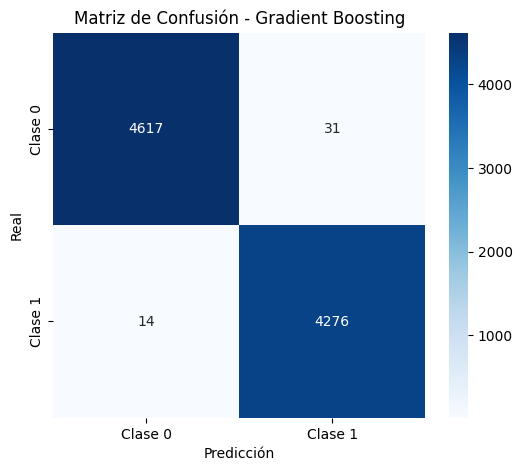

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Graficar la matriz de confusión para Gradient Boosting
plt.figure(figsize=(6, 5))
sns.heatmap([[4617, 31], [14, 4276]], annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Gradient Boosting')
plt.show()


## NP-Bayes

In [31]:
from sklearn.naive_bayes import MultinomialNB
# Entrenamiento
model = MultinomialNB()
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Evaluación
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[4376  272]
 [ 316 3974]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      4648
           1       0.94      0.93      0.93      4290

    accuracy                           0.93      8938
   macro avg       0.93      0.93      0.93      8938
weighted avg       0.93      0.93      0.93      8938



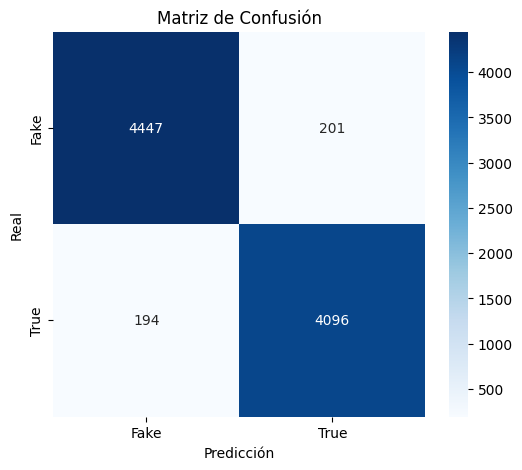

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Definir valores de la matriz de confusión
cm = np.array([[4447, 201],
               [194, 4096]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show();


# Random Forest


In [32]:
from sklearn.ensemble import RandomForestClassifier

# Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

# Evaluar el modelo
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

# Mostrar los resultados
conf_matrix_rf, class_report_rf


(array([[4641,    7],
        [  13, 4277]]),
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      4648\n           1       1.00      1.00      1.00      4290\n\n    accuracy                           1.00      8938\n   macro avg       1.00      1.00      1.00      8938\nweighted avg       1.00      1.00      1.00      8938\n')

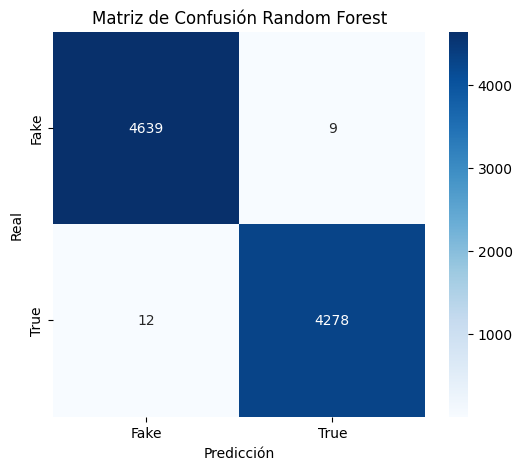

In [11]:
# Definir valores de la matriz de confusión
cm = np.array([[4639, 9],
               [12, 4278]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Random Forest')
plt.show();


## Supervector Machine

In [33]:
from sklearn.svm import SVC
# Entrenar el modelo SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_svm = svm_model.predict(X_test)

# Evaluar el modelo
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
class_report_svm = classification_report(y_test, y_pred_svm)

# Mostrar los resultados
conf_matrix_svm, class_report_svm

(array([[4621,   27],
        [  41, 4249]]),
 '              precision    recall  f1-score   support\n\n           0       0.99      0.99      0.99      4648\n           1       0.99      0.99      0.99      4290\n\n    accuracy                           0.99      8938\n   macro avg       0.99      0.99      0.99      8938\nweighted avg       0.99      0.99      0.99      8938\n')

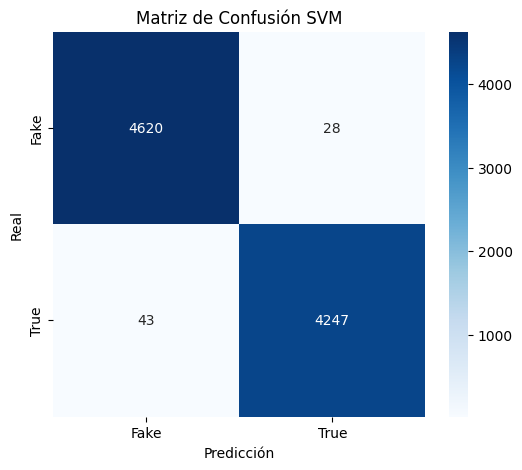

In [13]:
# Definir valores de la matriz de confusión
cm = np.array([[4620, 28],
               [43, 4247]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión SVM')
plt.show();


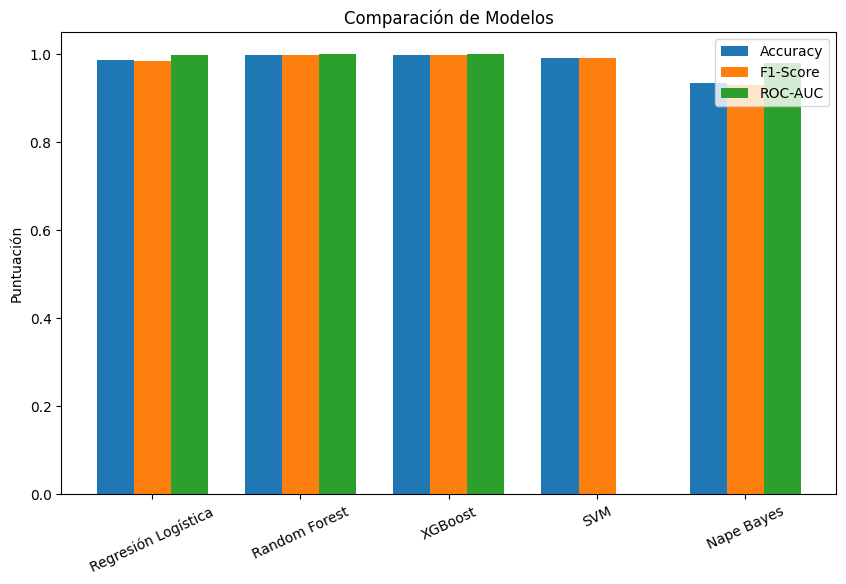

In [34]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
# 📊 Evaluar cada modelo
def evaluar_modelo(modelo, nombre):
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    
    return [acc, f1, auc]

# Guardar resultados en un diccionario
resultados = {
    "Regresión Logística": evaluar_modelo(logreg_model, "Regresión Logística"),
    "Random Forest": evaluar_modelo(rf_model, "Random Forest"),
    "XGBoost": evaluar_modelo(xgb_model, "XGBoost"),
    "SVM": evaluar_modelo(svm_model, "SVM"),
    "Nape Bayes":evaluar_modelo (model,"NPB")
}

# 📊 Graficar resultados
metricas = ["Accuracy", "F1-Score", "ROC-AUC"]
valores = np.array(list(resultados.values()))

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25
indices = np.arange(len(resultados))

# Crear barras para cada métrica
for i, metric in enumerate(metricas):
    ax.bar(indices + i * bar_width, valores[:, i], width=bar_width, label=metric)

# Etiquetas y formato
ax.set_xticks(indices + bar_width)
ax.set_xticklabels(resultados.keys(), rotation=25)
ax.set_ylabel("Puntuación")
ax.set_title("Comparación de Modelos")
ax.legend()

# Mostrar gráfico
plt.show()

In [63]:
# Ejemplo de noticia real
nueva_noticia = {
    'title': "Zelensky says UK and US volunteers survived Russian attack on hotel that killed four",
    'text': "The precise significance of US intelligence to Ukraine's war effort has, for obvious reasons, never been spelled out in detail.But any prolonged interruption in the supply of US intelligence could have a catastrophic impact on Ukraine’s ability to defend itself, particularly as the Trump administration has already decided to suspend vital military assistance.Most analysts agree that it performs two important functions: helping Ukraine to plan offensive operations against Russian forces, and giving Kyiv vital advance warning of threats posed by incoming Russian drones and missiles.Satellite information and signal intercepts give Ukrainian forces on the frontline a sense of where Russian forces are, their movements and likely intentions.Without US intelligence, Ukraine will not be able to make such effective use of long-range Western weaponry, like the US-made Himars launchers or Stormshadow missiles supplied by Britain and France.",
    }

In [65]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import spacy

# Cargar modelo spaCy optimizado sin NER (más rápido)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    doc = nlp(text)  # Procesa el texto con spaCy
    processed_words = [token.lemma_ for token in doc if token.text.lower() not in stop_words and not token.is_punct]
    return ' '.join(processed_words)

texto_noticia = nueva_noticia['text']

# Aplicar la función más rápido con multiprocessing
preprocess_text(texto_noticia)
#nueva_noticia['title'] = preprocess_text(nueva_noticia['title'])


"precise significance US intelligence Ukraine 's war effort obvious reason never spell detail prolong interruption supply US intelligence could catastrophic impact Ukraine ’s ability defend particularly Trump administration already decide suspend vital military assistance analyst agree perform two important function help Ukraine plan offensive operation russian force give Kyiv vital advance warning threat pose income russian drone missile satellite information signal intercept give ukrainian force frontline sense russian force movement likely intention without US intelligence Ukraine able make effective use long range western weaponry like US make Himars launcher stormshadow missile supply Britain France"

In [71]:
# Transformar el texto de la nueva noticia
nueva_noticia_tfidf = vectorizer.transform([texto_noticia])


In [72]:
# Hacer la predicción con el modelo entrenado
prediccion = svm_model.predict(nueva_noticia_tfidf)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [73]:
# Hacer la predicción con el modelo entrenado
prediccion = logreg_model.predict(nueva_noticia_tfidf)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [74]:
# Hacer la predicción con el modelo entrenado
prediccion = rf_model.predict(nueva_noticia_tfidf)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [75]:
# Hacer la predicción con el modelo entrenado
prediccion = gb_model.predict(nueva_noticia_tfidf)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [76]:
# Hacer la predicción con el modelo entrenado
prediccion = model.predict(nueva_noticia_tfidf)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia REAL


In [83]:
# Ejemplo de noticia real
nueva_noticia1= {
    'title': "Lockheed Martin Develops Giant Tactical Rubber Spider",
    'text': "BETHESDA, MD—Ushering in a new, highly advanced era of creepy-crawly warfare, defense contractor Lockheed Martin announced Friday that it had developed a giant tactical rubber spider. “With the introduction of this state-of-the-art rubber spider and its highly realistic, blood-curdling fangs, the face of combat has changed forever,” said CEO James Taiclet, explaining that the long-range, 250-foot-tall precision latex arachnid could be deployed anywhere in the world to scare the living daylights out of anyone in a 3,000-mile radius. “Enemy combatants are sure to flee when they see these immense, cutting-edge rubber spiders dropped into a war zone. Its power to freak out even the most well-trained military forces in the world should not be overstated.” Reached for comment, U.N. official confirmed they had drafted a resolution condemning the use of giant rubber spiders in war zones as inhumane and gross.",
    }

In [90]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import spacy

# Cargar modelo spaCy optimizado sin NER (más rápido)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    doc = nlp(text)  # Procesa el texto con spaCy
    processed_words = [token.lemma_ for token in doc if token.text.lower() not in stop_words and not token.is_punct]
    return ' '.join(processed_words)

texto_noticia1 = nueva_noticia1['text']

# Aplicar la función más rápido con multiprocessing
preprocess_text(texto_noticia1)
#nueva_noticia['title'] = preprocess_text(nueva_noticia['title'])


'BETHESDA MD Ushering new highly advanced era creepy crawly warfare defense contractor Lockheed Martin announce Friday develop giant tactical rubber spider introduction state art rubber spider highly realistic blood curdle fang face combat change forever say CEO James Taiclet explain long range 250 foot tall precision latex arachnid could deploy anywhere world scare live daylight anyone 3,000 mile radius enemy combatant sure flee see immense cut edge rubber spider drop war zone power freak even well train military force world overstate reach comment U.N. official confirm draft resolution condemn use giant rubber spider war zone inhumane gross'

In [91]:
# Transformar el texto de la nueva noticia
nueva_noticia_tfidf1 = vectorizer.transform([texto_noticia1])

In [92]:
# Hacer la predicción con el modelo entrenado
prediccion = svm_model.predict(nueva_noticia_tfidf1)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [93]:
# Hacer la predicción con el modelo entrenado
prediccion = logreg_model.predict(nueva_noticia_tfidf1)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [94]:
# Hacer la predicción con el modelo entrenado
prediccion = rf_model.predict(nueva_noticia_tfidf1)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [95]:
# Hacer la predicción con el modelo entrenado
prediccion = gb_model.predict(nueva_noticia_tfidf1)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [96]:
# Hacer la predicción con el modelo entrenado
prediccion = model.predict(nueva_noticia_tfidf1)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [100]:
# Ejemplo de noticia falsa
nueva_noticia2= {
    'title': " It Almost Weirder That Grown Man On Roblox Isn’t Grooming Children",
    'text': "SEATTLE—Voicing concern about the adult’s aberrant behavior, sources confirmed Monday that it was almost weirder that Richard Shea, a grown man on Roblox, wasn’t using the online gaming platform to groom children. “If he was on here trying to find underage players and lure them into some sort of sexual relationship, that would be super fucked-up, but at least it would explain his reasons for spending hours each day playing virtual experiences designed by children. This guy isn’t a predator, though,” said Roblox player Mason Briggs, 11, telling reporters that the fact that there was no sinister sexual motivation behind Shea’s dogged pursuit of high scores on games such as Blox Fruits and BedWars and that he seemed to play only for fun was bizarre and inexplicable. “I remember he invited me and a few friends to an in-game party where we could all play and communicate together. He never pressured us to reveal contact information or made any sort of inappropriate or explicit remark. He mostly just wanted tips on how to make it through the Ancient Ruins map on Adopt Me! It kind of gave me the creeps.” At press time, Briggs was reportedly all the more disturbed after receiving a private message from Shea informing her that he’d have even more time to play now that he had received tenure.",
    }

In [101]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import spacy

# Cargar modelo spaCy optimizado sin NER (más rápido)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    doc = nlp(text)  # Procesa el texto con spaCy
    processed_words = [token.lemma_ for token in doc if token.text.lower() not in stop_words and not token.is_punct]
    return ' '.join(processed_words)

texto_noticia2= nueva_noticia2['text']

# Aplicar la función más rápido con multiprocessing
preprocess_text(texto_noticia2)
#nueva_noticia['title'] = preprocess_text(nueva_noticia['title'])


'SEATTLE voice concern adult ’s aberrant behavior source confirm Monday almost weirder Richard Shea grown man Roblox not use online gaming platform groom child try find underage player lure sort sexual relationship would super fuck least would explain reason spend hour day play virtual experience design child guy n’t predator though say Roblox player Mason Briggs 11 tell reporter fact sinister sexual motivation behind Shea ’s dog pursuit high score game Blox Fruits BedWars seem play fun bizarre inexplicable remember invite friend game party could play communicate together never pressure we reveal contact information make sort inappropriate explicit remark mostly want tip make Ancient Ruins map Adopt kind give creep press time Briggs reportedly disturbed receive private message Shea inform ’d even time play receive tenure'

In [102]:
# Transformar el texto de la nueva noticia
nueva_noticia_tfidf2= vectorizer.transform([texto_noticia2])

In [112]:
# Hacer la predicción con el modelo entrenado
prediccion = svm_model.predict(nueva_noticia_tfidf2)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [113]:
# Hacer la predicción con el modelo entrenado
prediccion = logreg_model.predict(nueva_noticia_tfidf2)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [114]:
# Hacer la predicción con el modelo entrenado
prediccion = rf_model.predict(nueva_noticia_tfidf2)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [115]:
# Hacer la predicción con el modelo entrenado
prediccion = gb_model.predict(nueva_noticia_tfidf2)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [116]:
# Hacer la predicción con el modelo entrenado
prediccion = model.predict(nueva_noticia_tfidf2)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [109]:
# Ejemplo de noticia  verdadera
nueva_noticia3= {
    'title': "US 'destroying' world order, Ukraine's ambassador to UK says ",
    'text': "The US is destroying the established world order, Ukraine's ambassador to the UK has claimed.Valerii Zaluzhnyi said the White House had questioned the unity of the Western world and was taking more and more steps towards Russia, which launched a full-scale invasion of Ukraine in 2022.The comments come as the US puts pressure on Ukraine to make concessions ahead of any peace talks, and after a public clash between Ukrainian President Volodymyr Zelensky and his US counterpart Donald Trump.Zelensky has since said he is ready to work under Trump's 'strong leadership', an apparent cooling in tensions welcomed by Trump - and which comes after the US paused military aid to Kyiv."
}

In [110]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import spacy

# Cargar modelo spaCy optimizado sin NER (más rápido)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    doc = nlp(text)  # Procesa el texto con spaCy
    processed_words = [token.lemma_ for token in doc if token.text.lower() not in stop_words and not token.is_punct]
    return ' '.join(processed_words)

texto_noticia3= nueva_noticia3['text']

# Aplicar la función más rápido con multiprocessing
preprocess_text(texto_noticia3)
#nueva_noticia['title'] = preprocess_text(nueva_noticia['title'])


"US destroy establish world order Ukraine 's ambassador UK claim Valerii Zaluzhnyi say White House question unity western world take step towards Russia launch full scale invasion Ukraine 2022.the comment come US put pressure Ukraine make concession ahead peace talk public clash ukrainian President Volodymyr Zelensky US counterpart Donald Trump Zelensky since say ready work Trump 's strong leadership apparent cooling tension welcome Trump come US pause military aid Kyiv"

In [118]:
# Transformar el texto de la nueva noticia
nueva_noticia_tfidf3= vectorizer.transform([texto_noticia3])

In [119]:
# Hacer la predicción con el modelo entrenado
prediccion = svm_model.predict(nueva_noticia_tfidf3)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [120]:
# Hacer la predicción con el modelo entrenado
prediccion = logreg_model.predict(nueva_noticia_tfidf3)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [121]:
# Hacer la predicción con el modelo entrenado
prediccion = rf_model.predict(nueva_noticia_tfidf3)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [122]:
# Hacer la predicción con el modelo entrenado
prediccion = gb_model.predict(nueva_noticia_tfidf3)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA


In [123]:
# Hacer la predicción con el modelo entrenado
prediccion = model.predict(nueva_noticia_tfidf3)

# Mostrar resultado
print("Noticia REAL" if prediccion[0] == 1 else "Noticia FALSA")

Noticia FALSA
